### Deep Learning Based Object Detection

Architecture : Mobilenet based Single Shot Multi-Box (SSD)
Framework : Tensorflow

In [1]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [2]:
import os
import urllib.request
import tarfile

modelFile = "ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"

if not os.path.isdir("models"):
    os.mkdir("models")

if not os.path.isfile(modelFile):
    os.chdir("models")

    # Download the tensorflow Model
    url = "http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz"
    filename = "ssd_mobilenet_v2_coco_2018_03_29.tar.gz"
    urllib.request.urlretrieve(url, filename)
    print("Model downloaded")

    # Uncompress the tar.gz file (works on Windows too!)
    with tarfile.open(filename) as tar:
        tar.extractall()
    print("Model extracted")

    # Delete the tar.gz file
    os.remove(filename)
    print("Archive deleted")

    # Come back to the previous directory
    os.chdir("..")


Model downloaded
Model extracted
Archive deleted


In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [4]:
URL = r"https://www.dropbox.com/s/xoomeq2ids9551y/opencv_bootcamp_assets_NB13.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB13.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path) 

In [5]:
classFile  = "coco_class_labels.txt"
with open(classFile) as fp:
    labels = fp.read().split("\n")
    
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


The steps for performing infernece using a DNN model are summarized below:

- Load the model and input image into memory.
- Detect objects using a forward pass through the network.
- Display the detected objects with bounding boxes and class labels.

### Read Tensorflow Model

In [6]:
modelFile  = os.path.join("models", "ssd_mobilenet_v2_coco_2018_03_29", "frozen_inference_graph.pb")
configFile = os.path.join("models", "ssd_mobilenet_v2_coco_2018_03_29.pbtxt")
# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

### Detect Objects

In [7]:
# For ach file in the directory
def detect_objects(net, im, dim = 300):

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(im, 1.0, size=(dim, dim), mean=(0, 0, 0), swapRB=True, crop=False)

    # Pass blob to the network
    net.setInput(blob)

    # Peform Prediction
    objects = net.forward()
    return objects

In [8]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

In [11]:
def display_text(im, text, x, y):
    # Get text size
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]

    # Use text size to create a black rectangle
    cv2.rectangle(
        im,
        (x, y - dim[1] - baseline),
        (x + dim[0], y + baseline),
        (0, 0, 0),
        cv2.FILLED,
    )

    # Display text inside the rectangle
    cv2.putText(
        im,
        text,
        (x, y - 5),
        FONTFACE,
        FONT_SCALE,
        (0, 255, 255),
        THICKNESS,
        cv2.LINE_AA,
    )

In [12]:
def display_objects(im, objects, threshold=0.25):
    rows = im.shape[0]
    cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])

        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)

        # Check if the detection is of good quality
        if score > threshold:
            display_text(im, "{}".format(labels[classId]), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)

    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30, 10))
    plt.imshow(mp_img)
    plt.show()

### Result

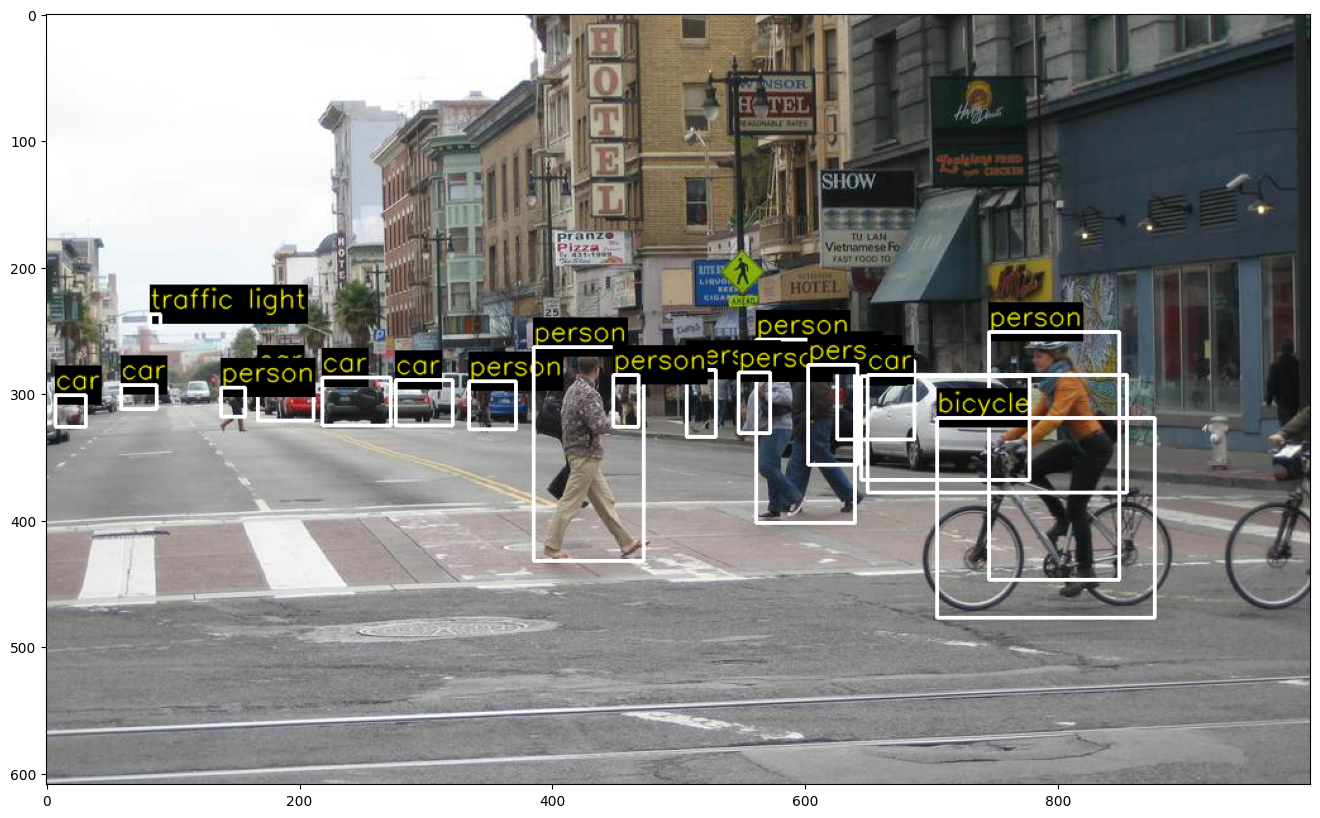

In [13]:
im = cv2.imread(os.path.join("images", "street.jpg"))
objects = detect_objects(net, im)
display_objects(im, objects)

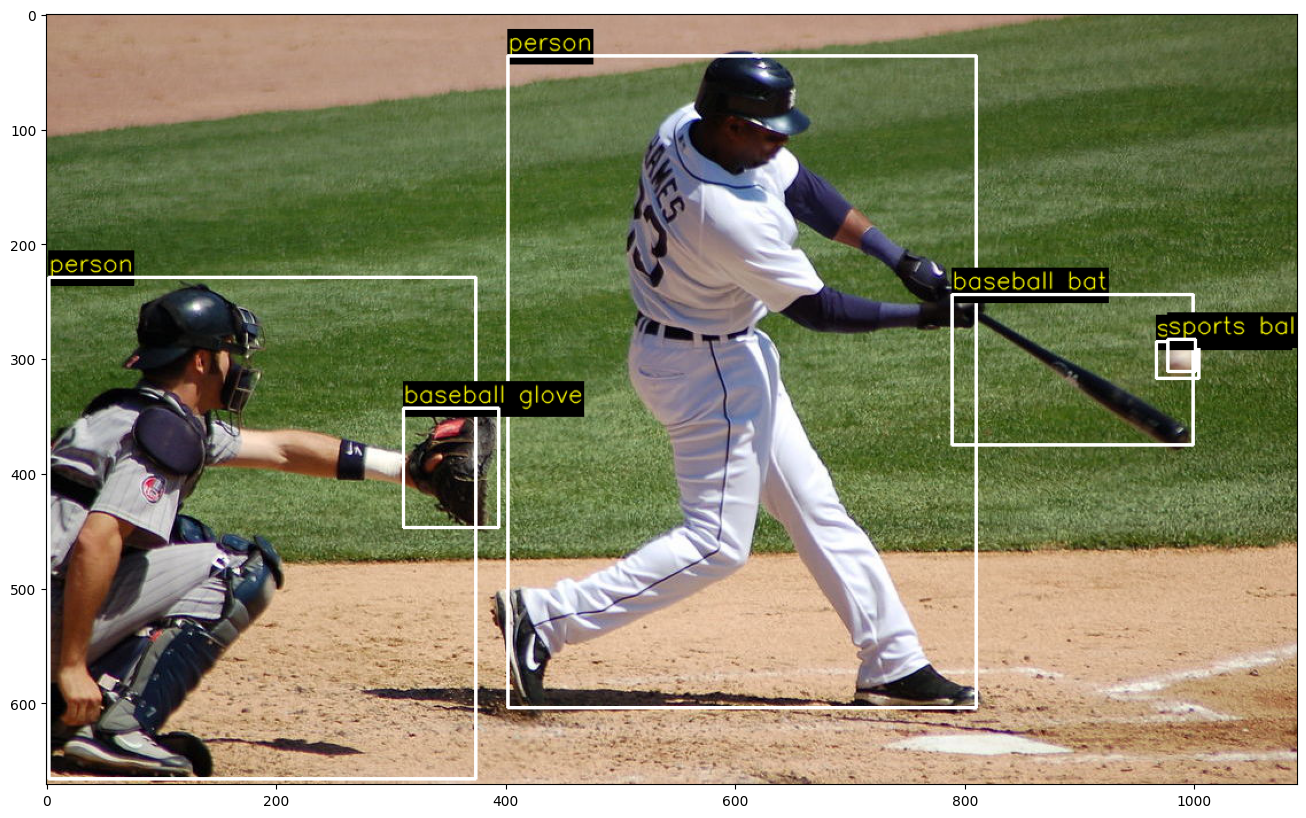

In [14]:
im = cv2.imread(os.path.join("images", "baseball.jpg"))
objects = detect_objects(net, im)
display_objects(im, objects, 0.2)

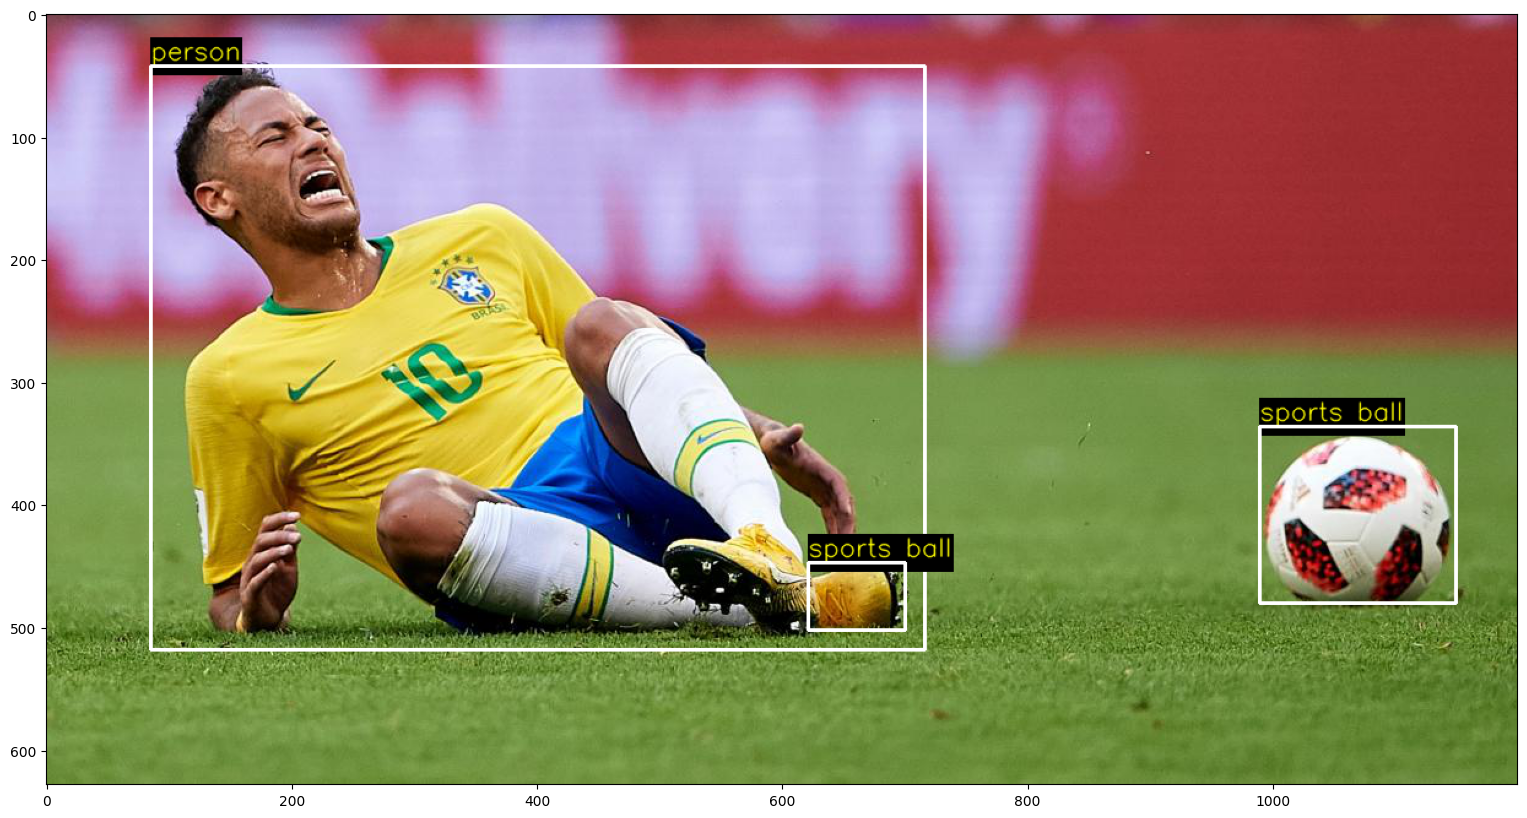

In [15]:
im = cv2.imread(os.path.join("images", "soccer.jpg"))
objects = detect_objects(net, im)
display_objects(im, objects)